In [1]:
## STANDARD PYTHON LIBS
import os
import sys
import json 
# import mpld3
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
# mpld3.enable_notebook()

## ADDING TO ROOT
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(ROOT_DIR)

## CUSTOM LIBS
import src.utils as utils
import src.model as modellib
from src.config import Config
import src.visualize as visualize
import src.mapillary as mapillary

# GPU LIBS
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import keras
import tensorflow as tf

cuda_version = os.popen("cat /usr/local/cuda/version.txt ").read()
print ('TF : ', tf.__version__, '  Keras : ', keras.__version__, '  CUDA : ', cuda_version)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


TF :  1.6.0   Keras :  2.1.4   CUDA :  CUDA Version 9.0.176



In [ ]:
if utils.check_gpu(verbose=0):
    pass
else:
    sys.exit(1)

# DATASET
 - Select any one of the options below

In [2]:
## OPTION1
if __name__ == "__main__":
    url_dataset = '/home/play/GOD_DATASET/open_datasets/mapillary'
    mapillary_mapper = '/home/play/playment/production/Mask_RCNN/demo/raw/merge__cityscapes_mapillary_v2.json'
    mapillary_config = mapillary.MapillaryConfig()
    testData = mapillary.MapillaryDataset(url_dataset, mapillary_mapper, mapillary_config, data_type = 'test')

Mode : test has 5000 images


In [3]:
## OPTION2
# img = skimage.io.imread('url')

# INFERENCE

In [3]:
MODEL_DIR = os.path.join(ROOT_DIR, 'demo', 'model', 'logs')
class InferenceConfig(mapillary.MapillaryConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
print (' - Batch Size : ', inference_config.BATCH_SIZE)
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)
# model_path = model.find_last()[1]
model_path = '/home/play/playment/production/Mask_RCNN/demo/model/logs/mapillary20180315T0317/mask_rcnn_mapillary_0158.h5'
model_path = '/home/play/playment/production/Mask_RCNN/demo/model/logs/mapillary20180315T0317/mask_rcnn_mapillary_0083.h5'
print (' - Model Path : ', model_path)

if model_path != None:
    model.load_weights(model_path, by_name=True)
else:
    sys.exit(1)

 - Batch Size :  1
 - Model Path :  /home/play/playment/production/Mask_RCNN/demo/model/logs/mapillary20180315T0317/mask_rcnn_mapillary_0083.h5


Image URL :  /home/play/GOD_DATASET/open_datasets/mapillary/mapillary-vistas-dataset_public_v1.0_test/testing/images/70hyKrMhdbW-phytIQMK2g.jpg
Image Shape :  (384, 512, 3)
len(images) : 1 || self.config.BATCH_SIZE : 1
 ---> Processing 1 images
 ----> image             shape: (384, 512, 3)         min:    0.00000  max:  254.00000
 ----> molded_images     shape: (1, 512, 512, 3)      min: -123.70000  max:  145.10000
 ----> image_metas       shape: (1, 23)               min:    0.00000  max:  512.00000
 -----> Mask (1, 100, 28, 28, 15)


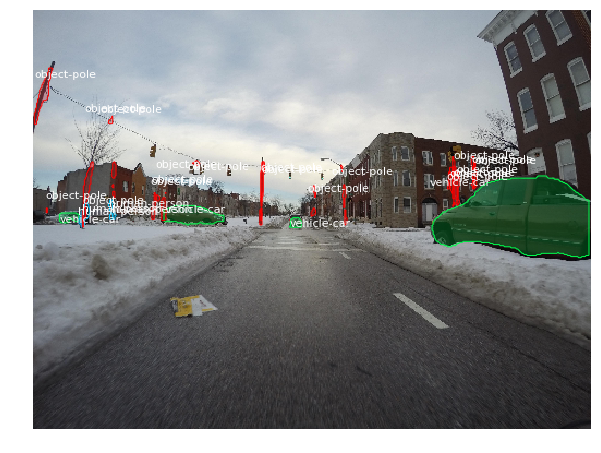

In [4]:
idx = 400
test_img = testData.load_image(idx)
print ('Image URL : ', testData.image_info[idx]['path'])
print ('Image Shape : ', test_img.shape)
results  = model.detect([test_img], verbose=1)
res = results[0]

if 'src.visualize' in sys.modules : del sys.modules['src.visualize']
import src.visualize as visualize
visualize.display_instances_play(test_img, res['rois'], res['masks'], res['class_ids'], testData.class_names, res['scores']
                            , show_boxes = False
                            , class_ids_exclude = [9, 12])
                            # , class_ids_exclude = [9, 12, 13])
## 9 - sidewalk, 12 - sky, 13 - poles                            

# GET JSON OF MASKS

In [28]:
import cv2
import json

def helper_img_resize(img, max_dim):
    # Image dimensions
    shape_ = img.shape
    if len(shape_) == 3:
        (r, c, ch) = shape_
    elif len(shape_) == 2:
        (r, c)   = shape_
    # Resize image to have max dimension MAX_DIM
    if r > c:
        new_r = max_dim
        new_c = round(c / r * max_dim)
    else:
        new_c = max_dim
        new_r = round(r / c * max_dim)
    resized_image = skimage.transform.resize(img, (new_r, new_c), preserve_range=True, mode='reflect').astype('uint8')

    return resized_image

def helper_getcontours(img_mask, res_obj, pt_index):
    res_instance = []
    
    if len(img_mask.shape) == 2:
        if list(np.unique(img_mask)) == [0,1]:
            _, contours, hierarchy = cv2.findContours(img_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
            # Step1 : hierarchy[0][x] = [next, prev, child, parent]
            hierarchy_idx = {}
            for idx, contour_info in enumerate(hierarchy[0]):
                if contour_info[3] == -1: # if no parent
                    hierarchy_idx[idx] = {}
                else: # if parent
                    hierarchy_idx[contour_info[3]] = {}

            # Step2 : loop over the different non-parent polygons
            for idx in hierarchy_idx:
                tmp_exterior = []
                contour_pts = [list(pt[0]) for pt in contours[idx]]
                if len(contour_pts) >= 3:
                    for pt in contours[idx]:
                        pt_index_tmp = 'p' + str(pt_index)
                        res_obj['points'][pt_index_tmp] = {'x' : str(pt[0][0]), 'y': str(pt[0][1])}
                        tmp_exterior.append(pt_index_tmp)
                        pt_index += 1
                res_instance.append({'exterior' : tmp_exterior})
    
    return res_instance, res_obj, pt_index

def helper_getmasks(res_predict, max_dim):
    #1. bloat the mask
    #2. cv2.findCountours
    total_masks = res_predict['masks'].shape[2]
    res_obj     = {'image_height' : -1, 'image_width' : -1, 'image_url' : '', 'instances' : [], 'points' : {}}
    
    pt_index = 0
    for mask_id in range(total_masks):
        print (mask_id, '/', total_masks, end='\r')
        tmp_mask              = res_predict['masks'][:,:,mask_id]
        tmp_mask              = helper_img_resize(tmp_mask, max_dim)
        tmp_class_id          = res_predict['class_ids'][mask_id]
        # tmp_class_name        = class_names[tmp_class_id]
        res_instance, res_obj, pt_index = helper_getcontours(tmp_mask, res_obj, pt_index)
        tmp_instance          = {'label' : str(tmp_class_id), 'segments' : res_instance}
        res_obj['instances'].append(tmp_instance)
    
    return res_obj


if __name__ == "__main__":
    idx = 402
    test_img = testData.load_image(idx)
    results  = model.detect([test_img], verbose=1)
    res      = results[0]
    test_img_orig = skimage.io.imread(testData.image_info[idx]['path'])

    res_instances = helper_getmasks(res, 2592)

len(images) : 1 || self.config.BATCH_SIZE : 1
 ---> Processing 1 images
 ----> image             shape: (384, 512, 3)         min:    0.00000  max:  255.00000
 ----> molded_images     shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000
 ----> image_metas       shape: (1, 23)               min:    0.00000  max:  512.00000
 -----> Mask (1, 100, 28, 28, 15)


In [29]:
import pprint
pprint.pprint(res_instances)
tmp = res_instances['points']['p999']['x']
print (type(tmp))
# json.dumps(res_instances['points'])

{'image_height': -1,
 'image_url': '',
 'image_width': -1,
 'instances': [{'label': '12',
                'segments': [{'exterior': ['p0',
                                           'p1',
                                           'p2',
                                           'p3',
                                           'p4',
                                           'p5',
                                           'p6',
                                           'p7',
                                           'p8',
                                           'p9',
                                           'p10',
                                           'p11',
                                           'p12',
                                           'p13',
                                           'p14',
                                           'p15',
                                           'p16',
                                           'p17',
                    

 'points': {'p0': {'x': '13', 'y': '23'},
            'p1': {'x': '13', 'y': '781'},
            'p10': {'x': '170', 'y': '766'},
            'p100': {'x': '742', 'y': '918'},
            'p1000': {'x': '1228', 'y': '919'},
            'p1001': {'x': '1228', 'y': '923'},
            'p1002': {'x': '1232', 'y': '923'},
            'p1003': {'x': '1233', 'y': '924'},
            'p1004': {'x': '1233', 'y': '938'},
            'p1005': {'x': '1237', 'y': '938'},
            'p1006': {'x': '1238', 'y': '939'},
            'p1007': {'x': '1238', 'y': '948'},
            'p1008': {'x': '1242', 'y': '948'},
            'p1009': {'x': '1243', 'y': '949'},
            'p101': {'x': '857', 'y': '918'},
            'p1010': {'x': '1243', 'y': '958'},
            'p1011': {'x': '1252', 'y': '958'},
            'p1012': {'x': '1253', 'y': '959'},
            'p1013': {'x': '1253', 'y': '963'},
            'p1014': {'x': '1257', 'y': '963'},
            'p1015': {'x': '1258', 'y': '964'},
          

            'p448': {'x': '2205', 'y': '361'},
            'p449': {'x': '2209', 'y': '361'},
            'p45': {'x': '534', 'y': '813'},
            'p450': {'x': '2209', 'y': '357'},
            'p451': {'x': '2210', 'y': '356'},
            'p452': {'x': '2214', 'y': '356'},
            'p453': {'x': '2214', 'y': '352'},
            'p454': {'x': '2215', 'y': '351'},
            'p455': {'x': '2224', 'y': '351'},
            'p456': {'x': '2224', 'y': '347'},
            'p457': {'x': '2225', 'y': '346'},
            'p458': {'x': '2234', 'y': '346'},
            'p459': {'x': '2234', 'y': '342'},
            'p46': {'x': '534', 'y': '817'},
            'p460': {'x': '2235', 'y': '341'},
            'p461': {'x': '2249', 'y': '341'},
            'p462': {'x': '2249', 'y': '337'},
            'p463': {'x': '2250', 'y': '336'},
            'p464': {'x': '2259', 'y': '336'},
            'p465': {'x': '2259', 'y': '332'},
            'p466': {'x': '2260', 'y': '331'},
            'p467

In [31]:
from flask import Flask, jsonify
from flask import Response
app = Flask(__name__)
# with app.app_context():
with app.test_request_context():
    jsonify(res_instances)
#     resp = Response(response=json.dumps(res_instances['points']),
#         status=200,
#         mimetype="application/json")
# res_instances['points'] = json.loads(json.dumps(res_instances['points']))
# print (res_instances['points'].keys())
# a = json.dumps(res_instances['points'])



In [ ]:
from shapely import geometry
from descartes import PolygonPatch

f, axarr = plt.subplots(1, figsize=(15,15))
axarr.imshow(test_img_orig)
print ('Total Instances : ', len(res_instances['instances']))
for inst_id, instance in enumerate(res_instances['instances']):
    if inst_id != 2:
        continue
    segments = res_instances['instances'][inst_id]['segments']
    print ('Class Name : ', res_instances['instances'][inst_id]['label'])
    print ('Segment count : ', len(segments))
    for segment in segments:
        pts_idx = segment['exterior']
        pts = []
        for pt_idx in pts_idx:
            tmp_pt = res_instances['points'][pt_idx]
            pts.append([tmp_pt['x'], tmp_pt['y']])
        poly = geometry.Polygon(pts)
        patch = PolygonPatch(poly, facecolor = [0,0,1], edgecolor = [0,0,1], alpha = 0.9)
        axarr.add_patch(patch)

# SCRATCHPAD